In [2]:
# Importações
import os
import sys
import cv2
import random
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split

In [3]:
# Etapa de Pré-processamento
def preprocess_img (img, crop_area, height, width):
    rszed_img = cv2.resize(img,(height, width)) # Redimensiona a imagem para o tamanho desejado
    rszed_img = rszed_img[crop_area:-crop_area, crop_area:-crop_area] # Seleciona a área delimitada para remover regiões sem informação
    plt.imshow(rszed_img)
    return rszed_img

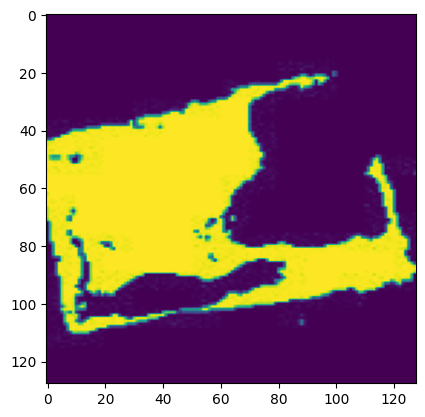

In [4]:
crop_area = 10
new_width = 128 + 2*crop_area
new_height = 128 + 2*crop_area

img_folder_path = "./water-bodies-dataset/Images"
mask_folder_path = "./water-bodies-dataset/Masks"

img_list = []
mask_list = []

### Lê as imagens, faz o pré-processamento e as armazena em um array
for filename in os.listdir(img_folder_path):
    img_path = os.path.join(img_folder_path, filename)
    
    # Verifica se é arquivo e se é uma imagem .jpg
    if os.path.isfile(img_path) and filename.lower().endswith('.jpg'):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = preprocess_img(img,crop_area,new_height,new_width)
        img_list.append(img)
        
img_list = np.array(img_list) # converte a lista para array

### Lê as máscaras, faz o pré-processamento e as armazena em um array
for filename in os.listdir(mask_folder_path):
    mask_path = os.path.join(mask_folder_path, filename)
    
    # Verifica se é arquivo e se é uma imagem .jpg
    if os.path.isfile(mask_path) and filename.lower().endswith('.jpg'):
        mask_img = cv2.imread(mask_path, 0)
        mask_img = preprocess_img(mask_img,crop_area,new_height,new_width)
        mask_list.append(mask_img)
        
mask_list = np.array(mask_list) # converte a lista para array

2841 2841
(128, 128, 3) (128, 128)


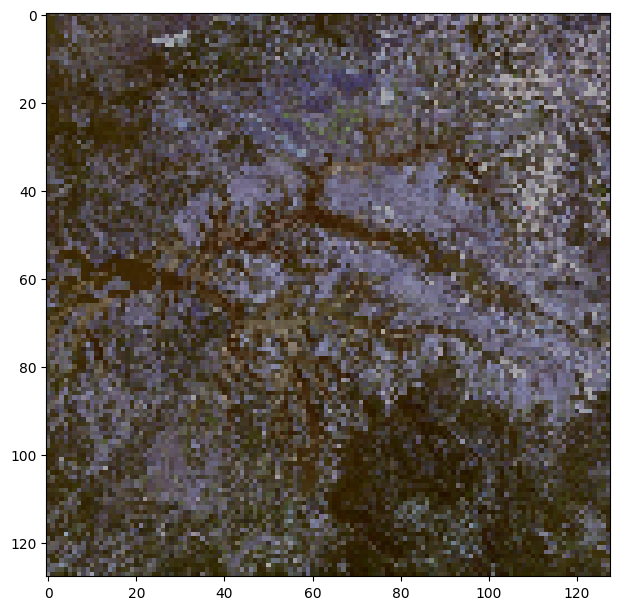

In [5]:
# Confere se o número de imagens e máscaras é o mesmo
print(len(img_list), len(mask_list))
# Confere se o shape das imagens é igual
print(img_list[0].shape, mask_list[0].shape)

plt.figure(figsize=(16, 8))
####
plt.subplot(1, 2, 1)
plt.imshow(img_list[0])
plt.show()

In [6]:
# Verificação do intervalo de valores das imagens e máscaras
print('Valor min e max da imagem:')
print (np.min(img_list[0]), np.max(img_list[0]))

print('Valor min e max da máscara:')
print (np.min(mask_list[0]), np.max(mask_list[0]))

Valor min e max da imagem:
0 185
Valor min e max da máscara:
0 255


In [7]:
# Normalização das imagens e máscaras
norm_img_list = img_list/255
norm_mask_list = mask_list/255


# Conferir outro método de normalização!

In [8]:
# Valores após a normalização
print('Intervalo de valores da imagem após a normalização:')
print(np.min(norm_img_list[0]), np.max(norm_img_list[0]))

print('Intervalo de valores da máscara após a normalização:')
print(np.min(norm_mask_list[0]), np.max(norm_mask_list[0]))

Intervalo de valores da imagem após a normalização:
0.0 0.7254901960784313
Intervalo de valores da máscara após a normalização:
0.0 1.0


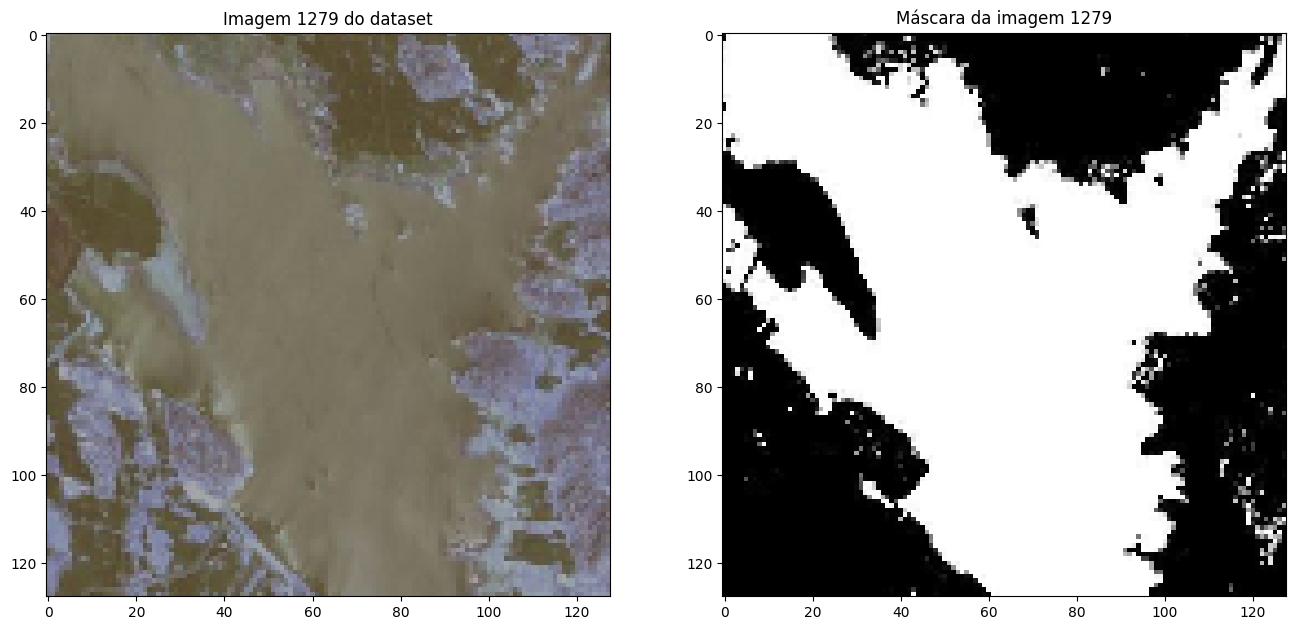

In [9]:
random_num = random.randint(0,len(img_list)-1) # Seleciona randomicamente uma imagem e sua máscara para exibir

plt.figure(figsize=(16, 8))
####
plt.subplot(1, 2, 1)
plt.imshow(norm_img_list[random_num])
plt.title('Imagem ' + str(random_num) + ' do dataset')
####
plt.subplot(1, 2, 2)
plt.imshow(norm_mask_list[random_num], cmap='gray')
plt.title('Máscara da imagem ' + str(random_num))
####
plt.show()

In [10]:
# Divisão dos dados em treino e teste
t_size = 0.2 # 20% dos dados serão usados para teste
rand_state = 42 # Garante que a divisão será a mesma a cada execução
img_train, img_test, mask_train, mask_test = train_test_split(norm_img_list, norm_mask_list, test_size = t_size, random_state = rand_state)

In [11]:
# Definição do modelo U-Net
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) # Cria um objeto Input do Keras com as dimensões da imagem
    s = inputs

    ### Caminho de Contração da U-Net
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    ### Caminho de Expansão da U-Net
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])    
    return model

In [12]:
def get_model():
    return simple_unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [13]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history=model.fit(img_train, mask_train,
          batch_size=4, 
          epochs=3,
          verbose=1,
          validation_data=(img_test, mask_test))

Epoch 1/3
568/568 [==============================] - 253s 439ms/step - loss: 0.5186 - accuracy: 0.6549 - val_loss: 0.4986 - val_accuracy: 0.6766
Epoch 2/3
568/568 [==============================] - 257s 452ms/step - loss: 0.4667 - accuracy: 0.6801 - val_loss: 0.5165 - val_accuracy: 0.6154
Epoch 3/3
568/568 [==============================] - 255s 449ms/step - loss: 0.4289 - accuracy: 0.7028 - val_loss: 0.4141 - val_accuracy: 0.7157


277
1/1 [==============================] - 0s 413ms/step


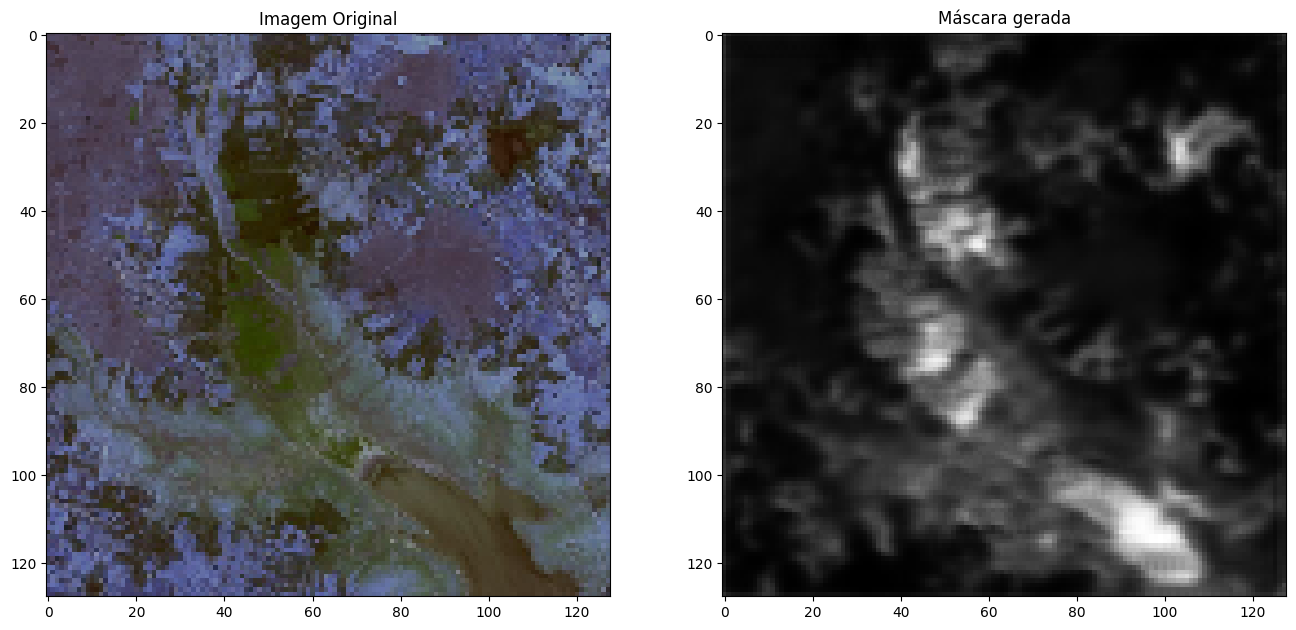

155
1/1 [==============================] - 0s 53ms/step


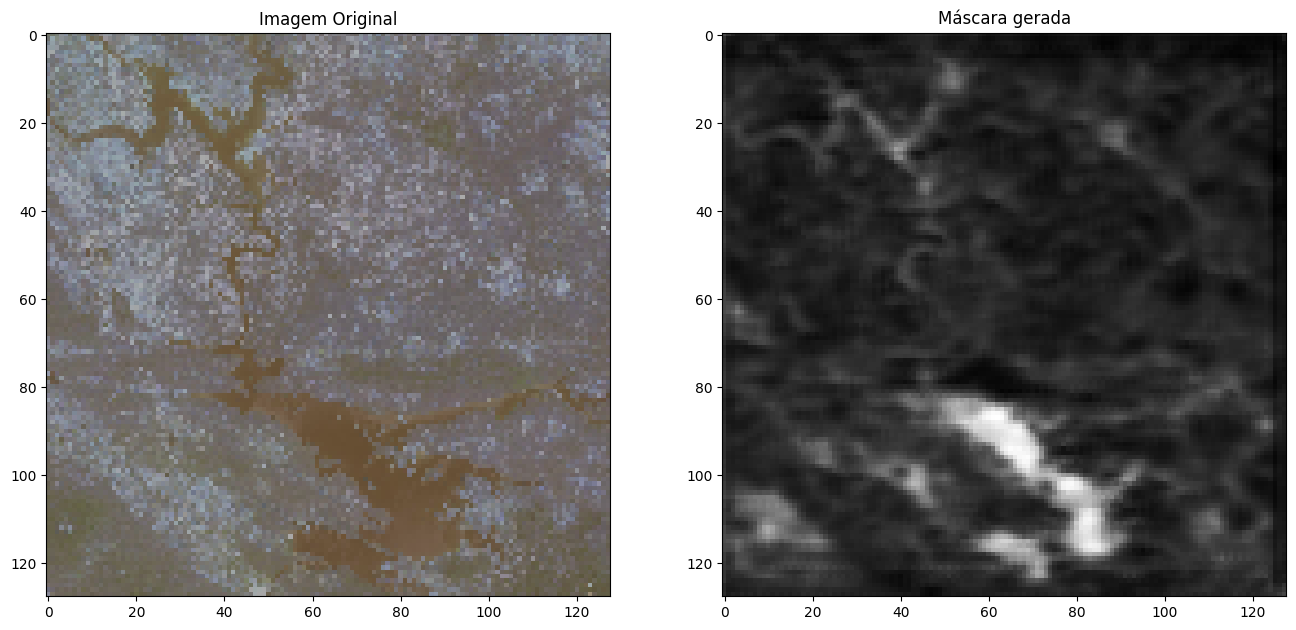

410
1/1 [==============================] - 0s 65ms/step


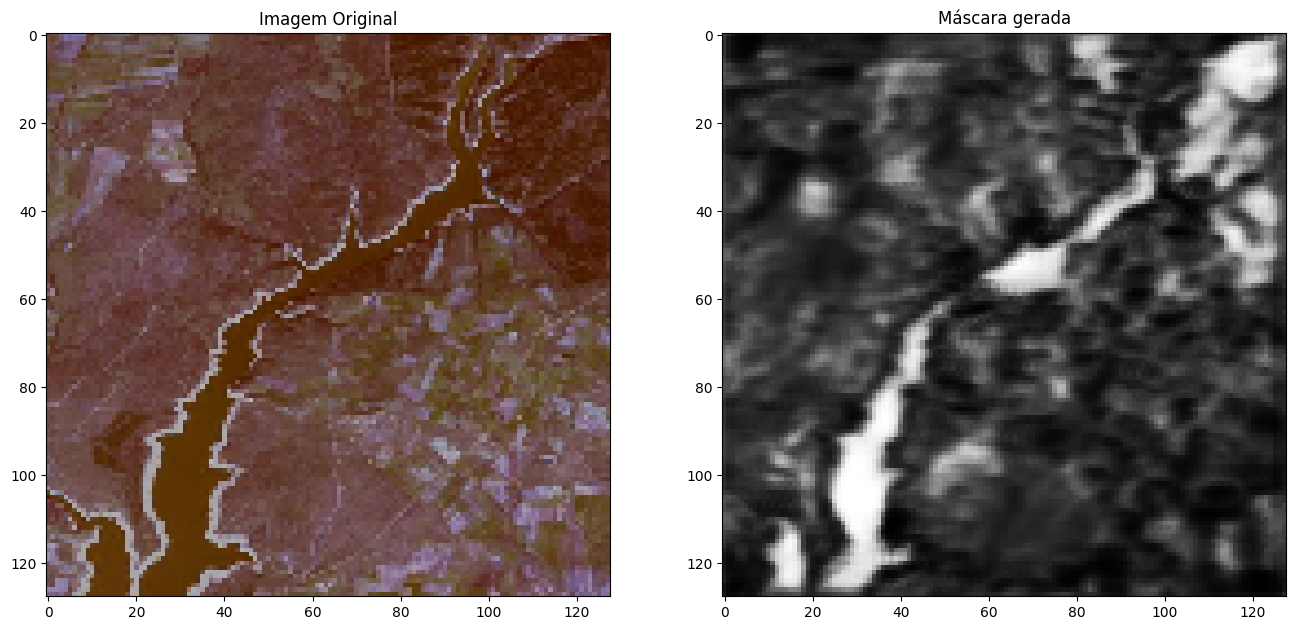

310
1/1 [==============================] - 0s 55ms/step


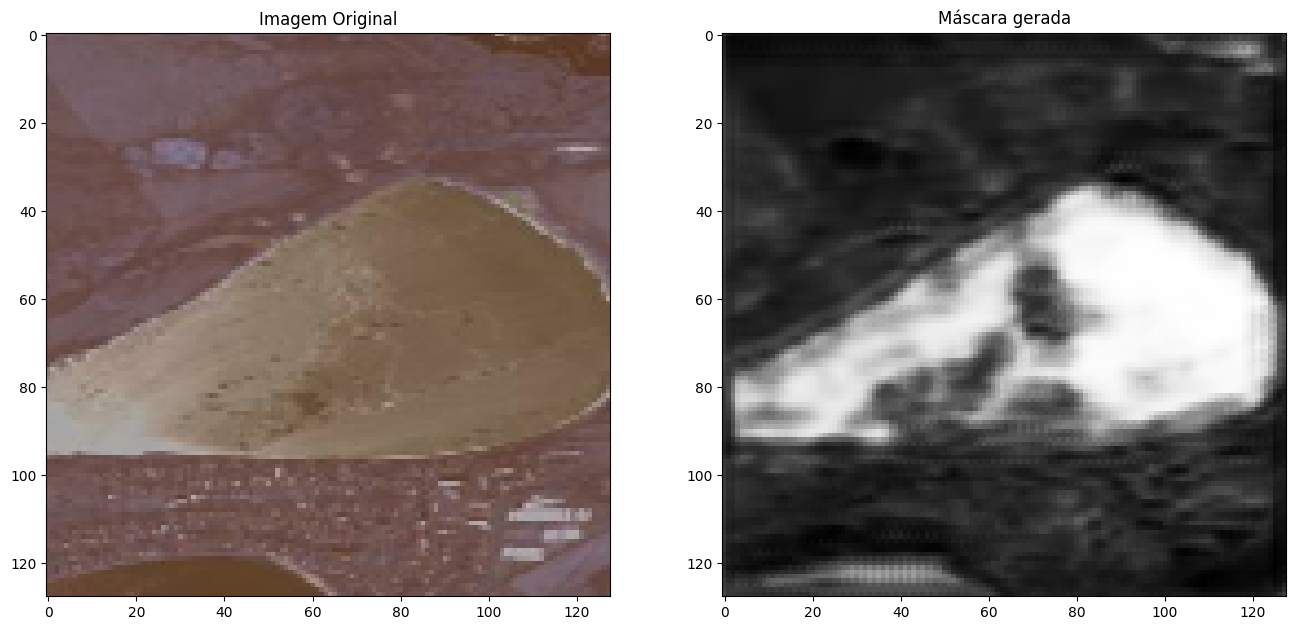

552
1/1 [==============================] - 0s 57ms/step


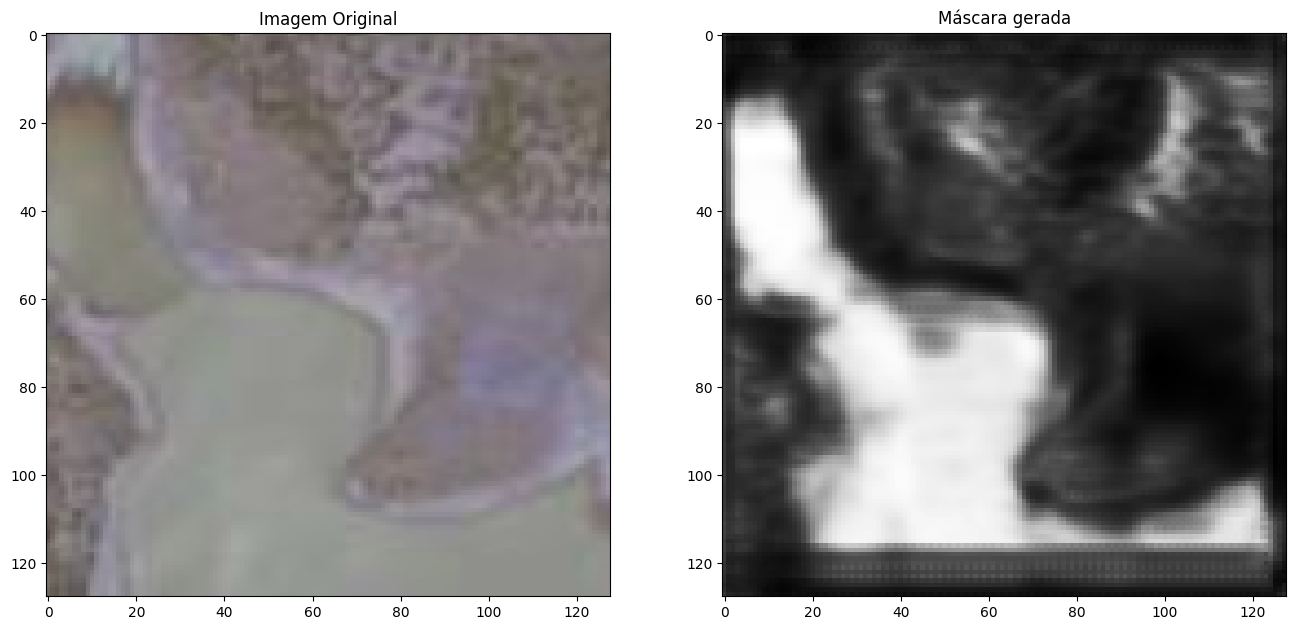

101
1/1 [==============================] - 0s 57ms/step


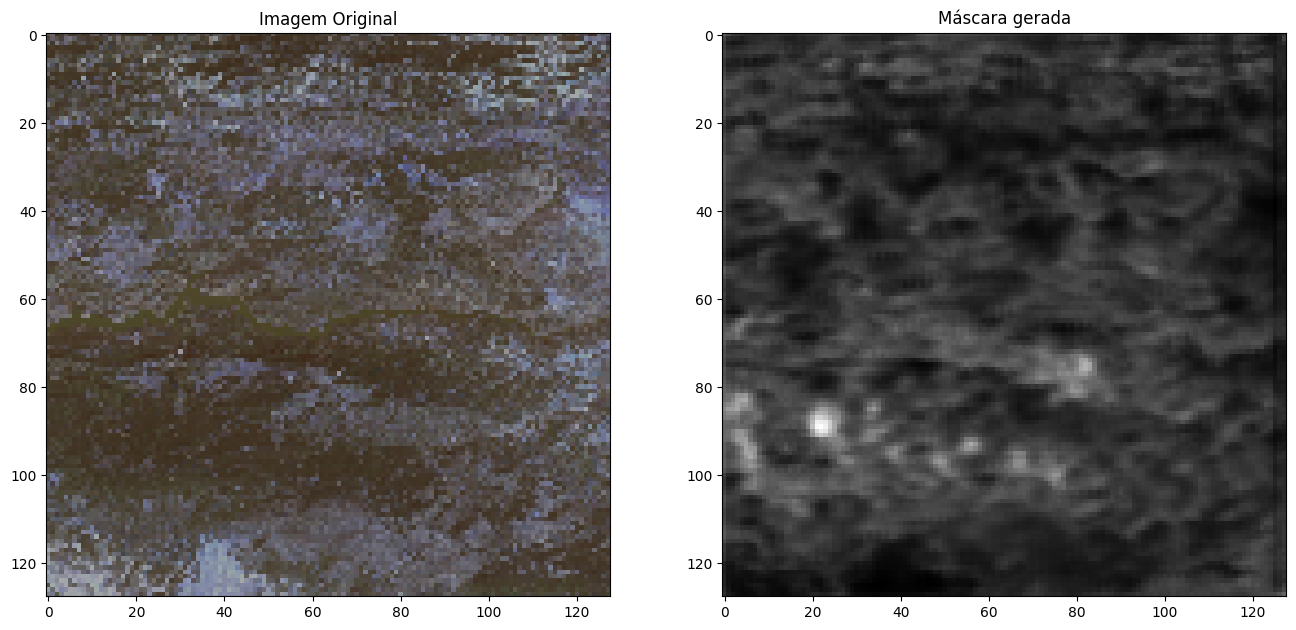

159
1/1 [==============================] - 0s 36ms/step


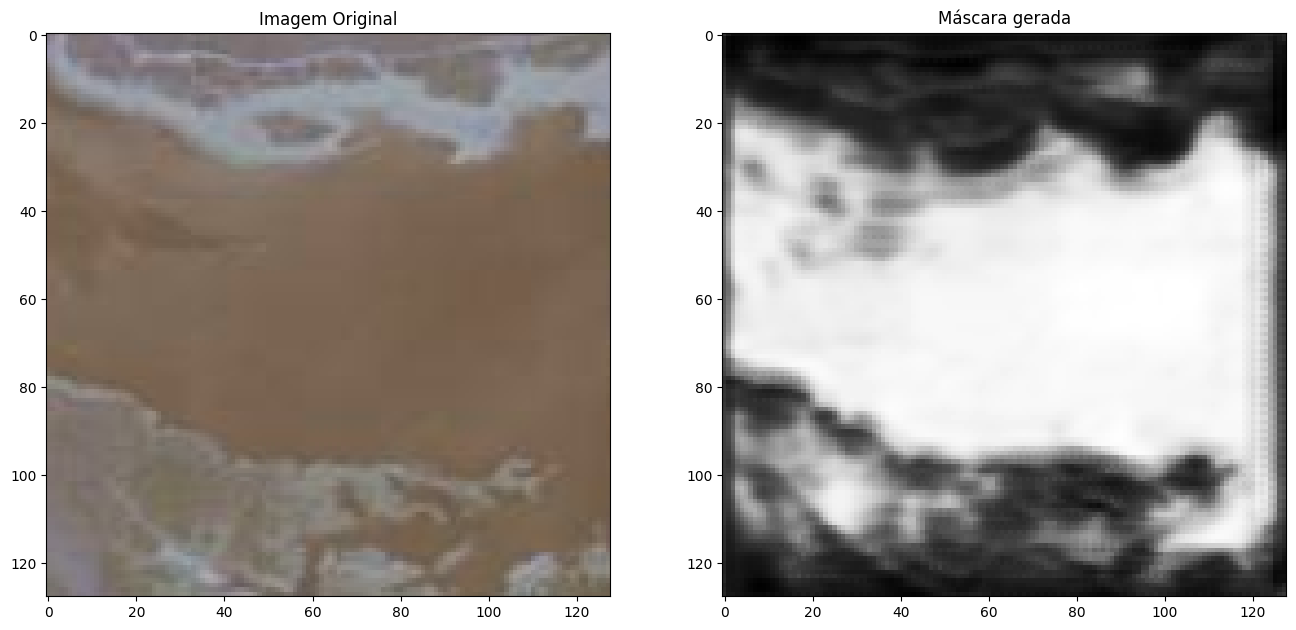

375
1/1 [==============================] - 0s 37ms/step


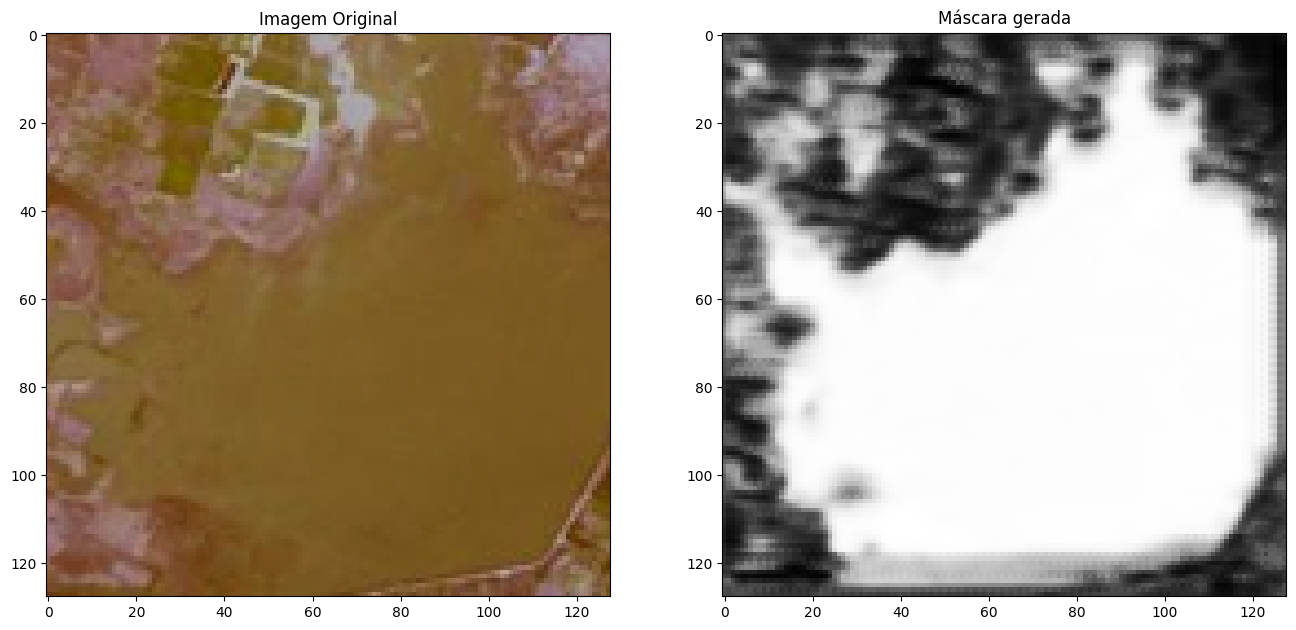

51
1/1 [==============================] - 0s 36ms/step


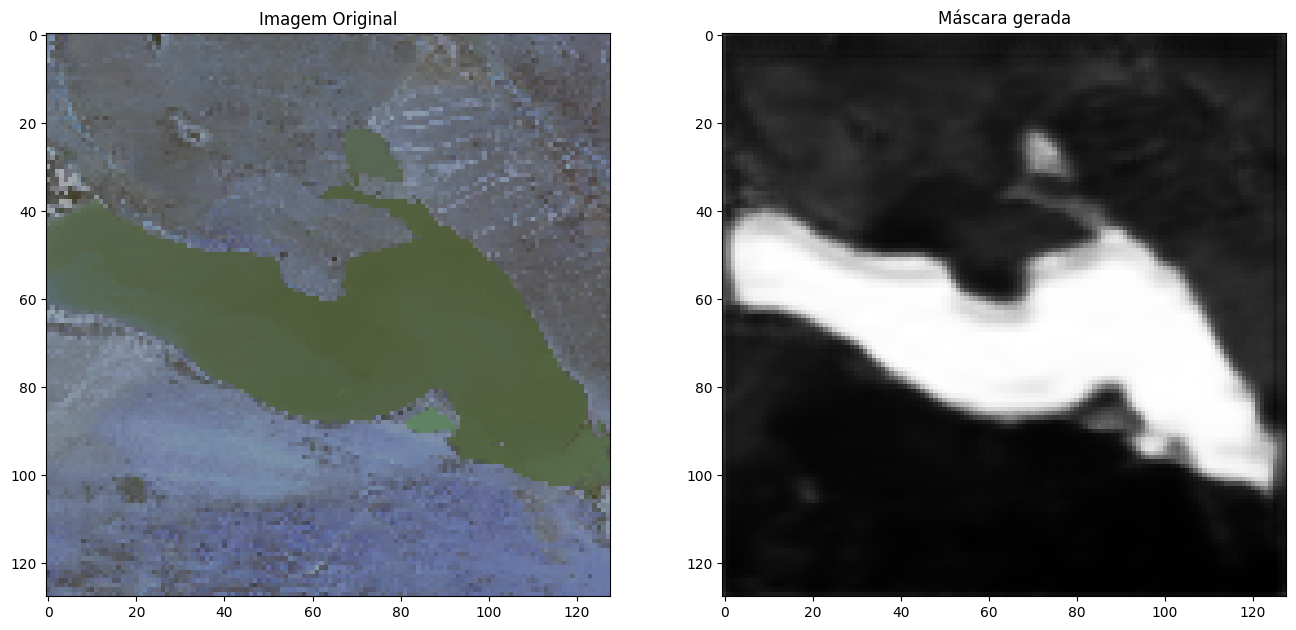

117
1/1 [==============================] - 0s 42ms/step


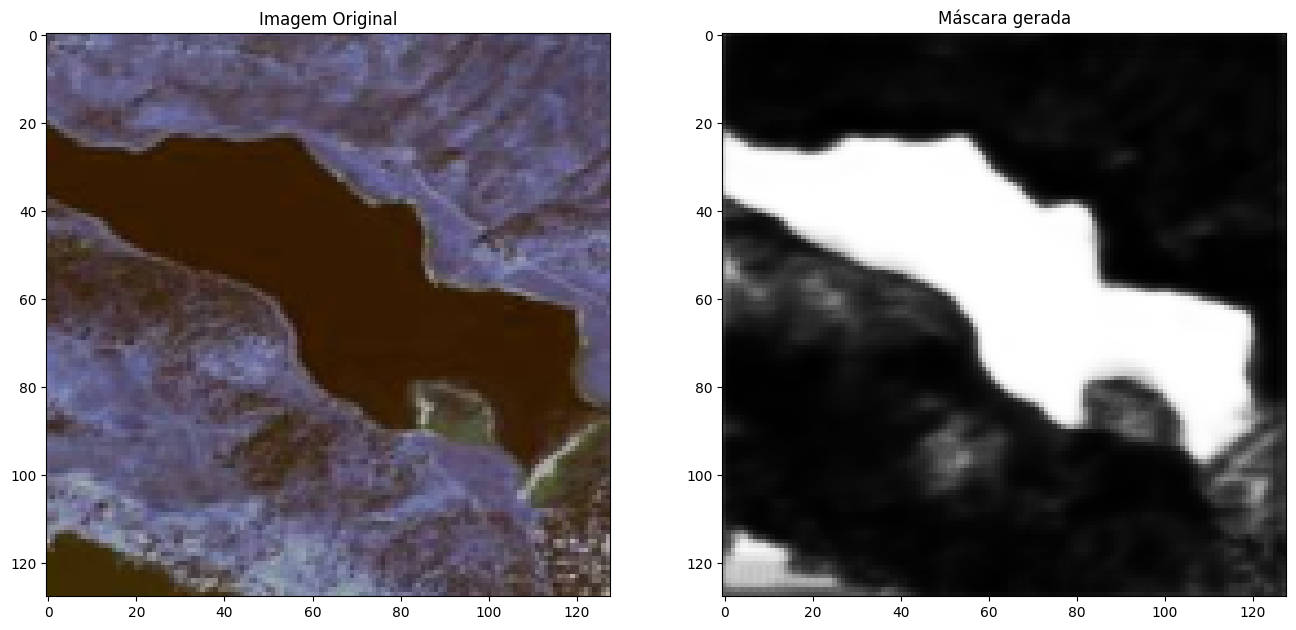

242
1/1 [==============================] - 0s 67ms/step


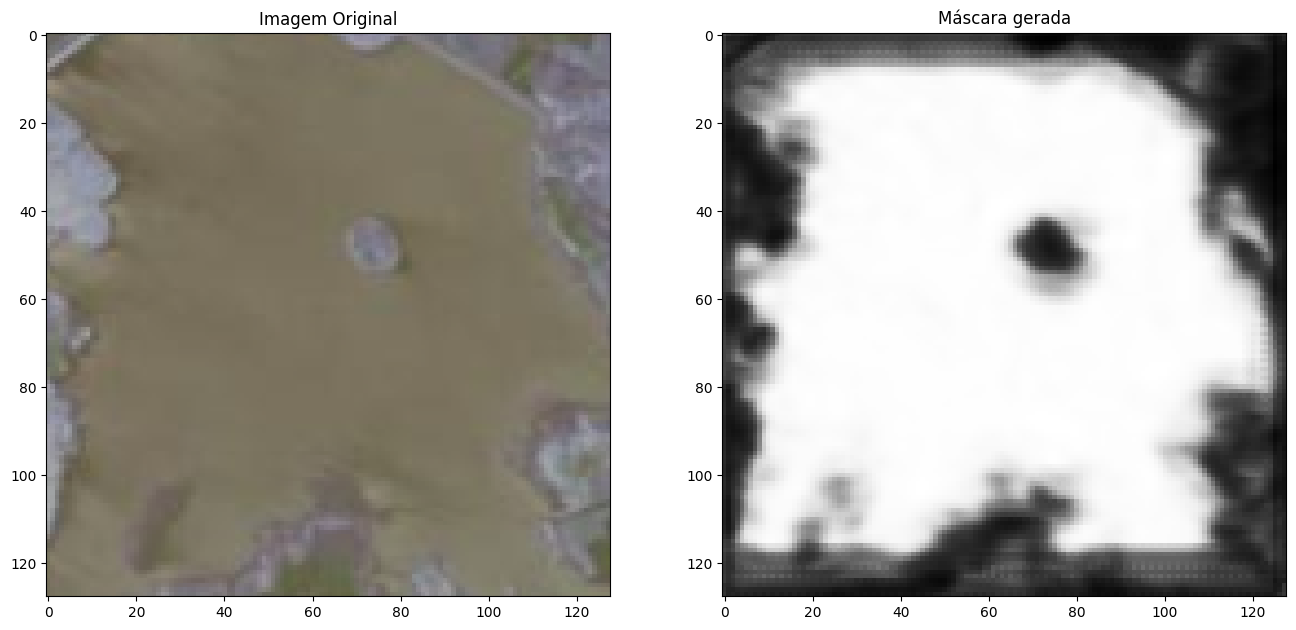

408
1/1 [==============================] - 0s 40ms/step


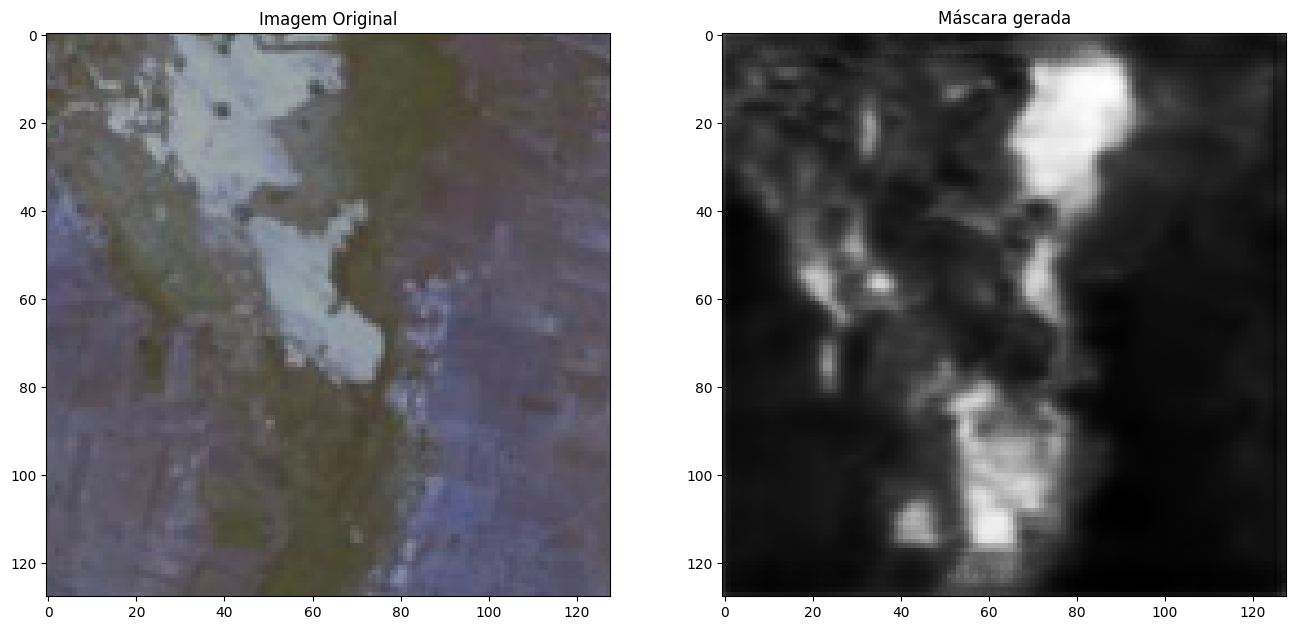

41
1/1 [==============================] - 0s 45ms/step


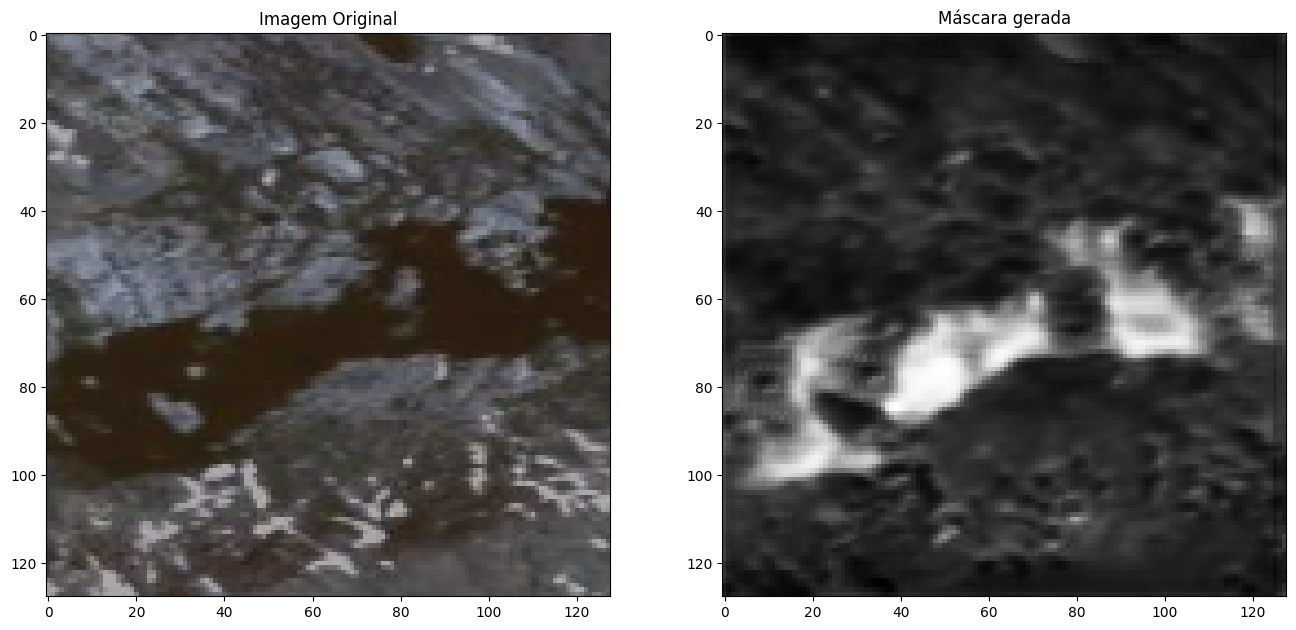

501
1/1 [==============================] - 0s 48ms/step


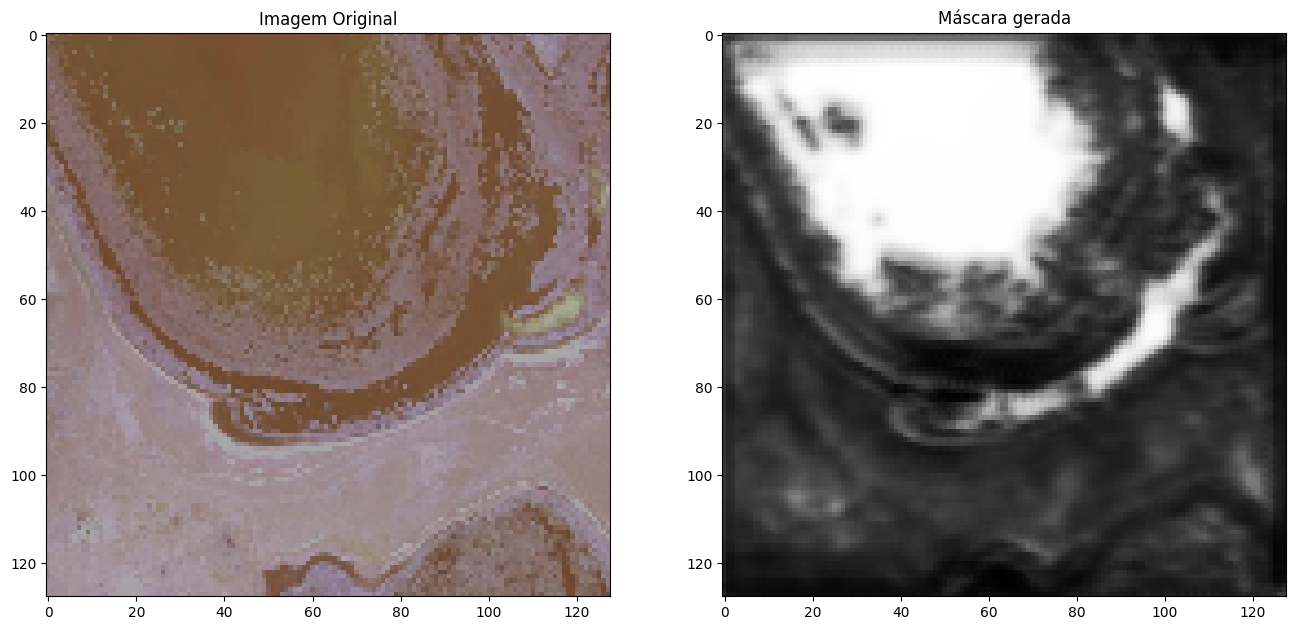

230
1/1 [==============================] - 0s 35ms/step


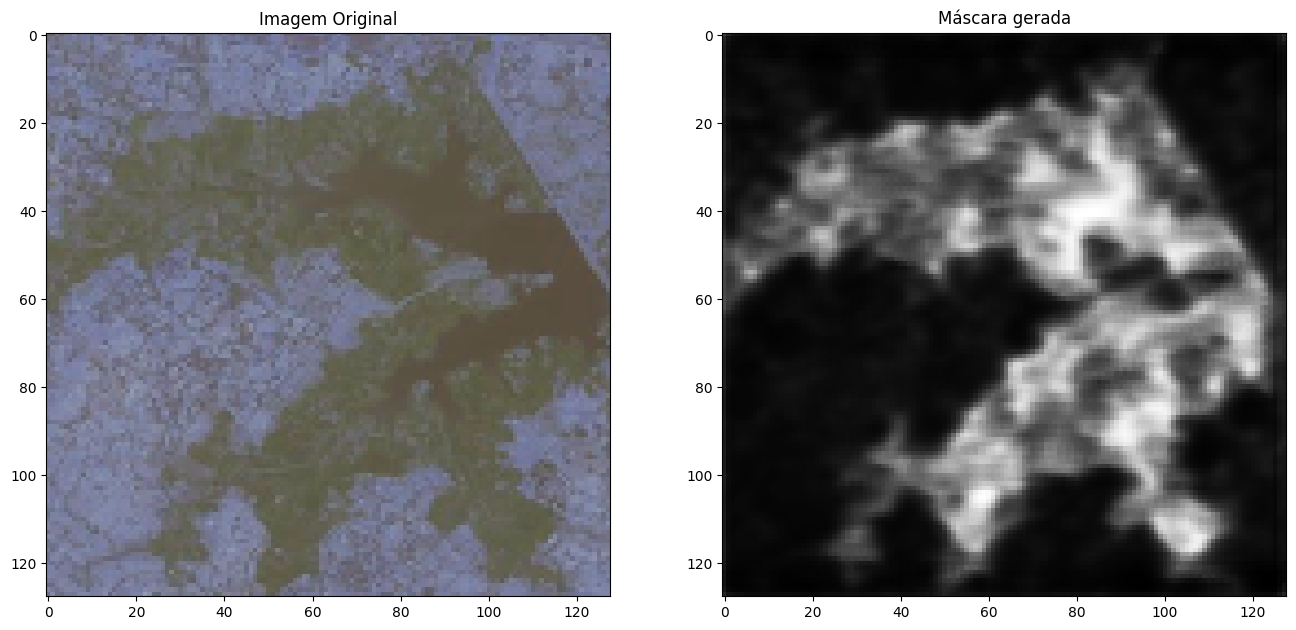

153
1/1 [==============================] - 0s 51ms/step


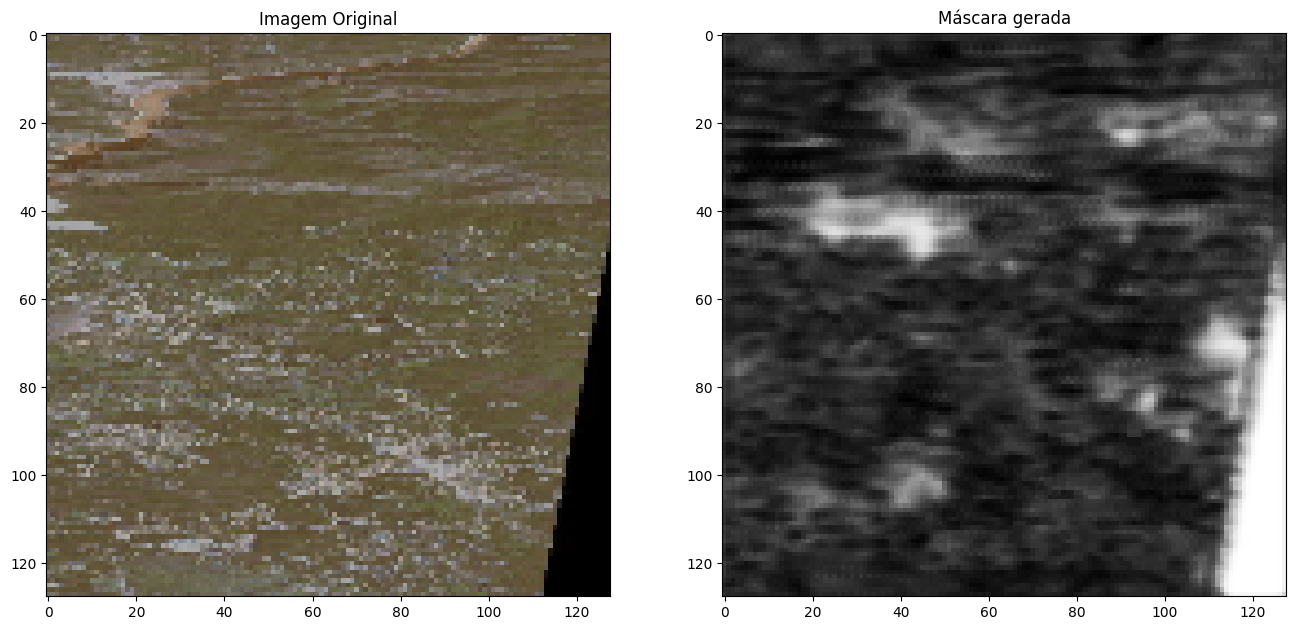

311
1/1 [==============================] - 0s 51ms/step


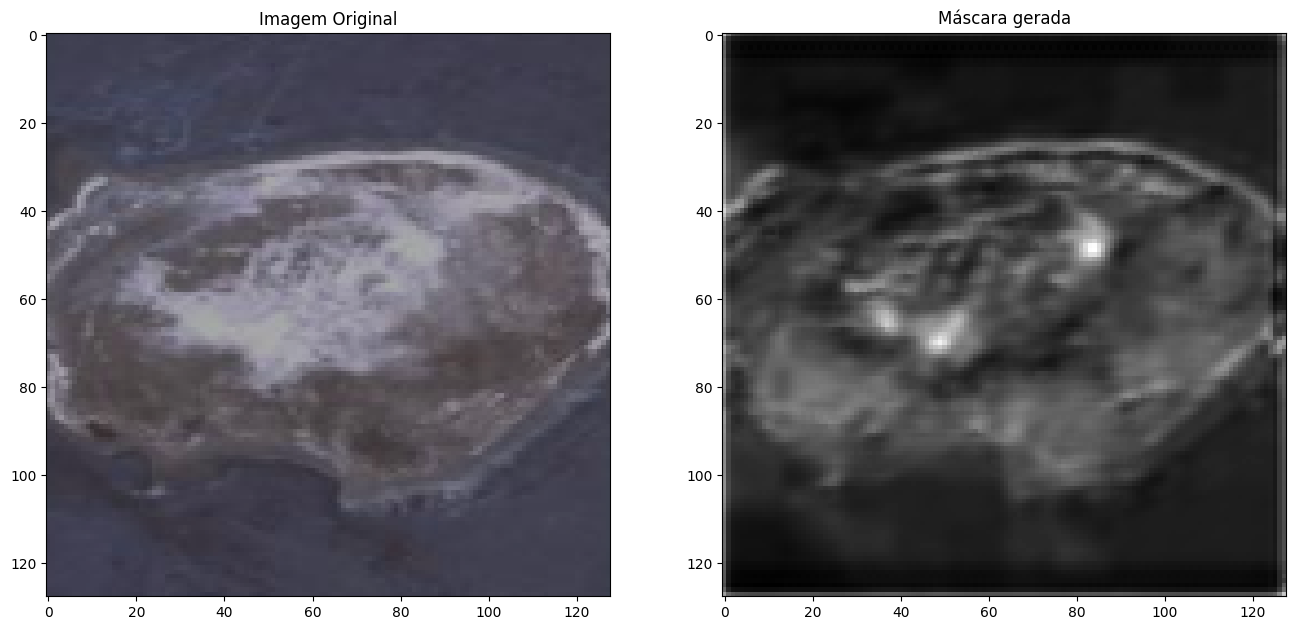

36
1/1 [==============================] - 0s 48ms/step


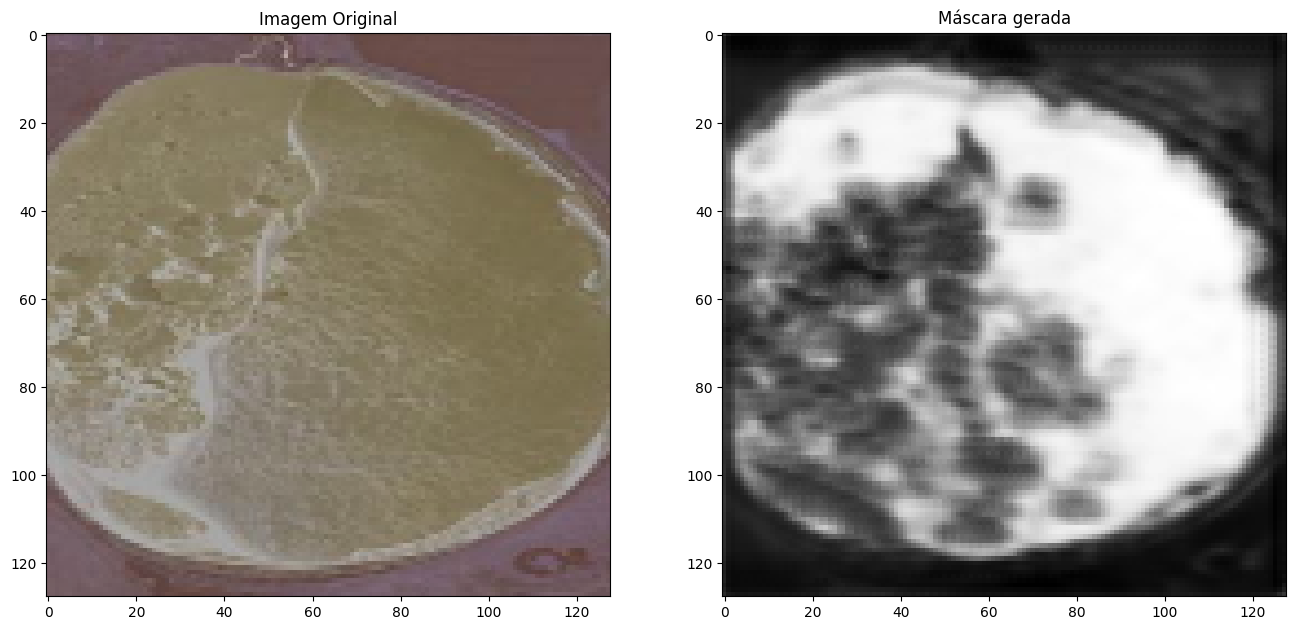

312
1/1 [==============================] - 0s 54ms/step


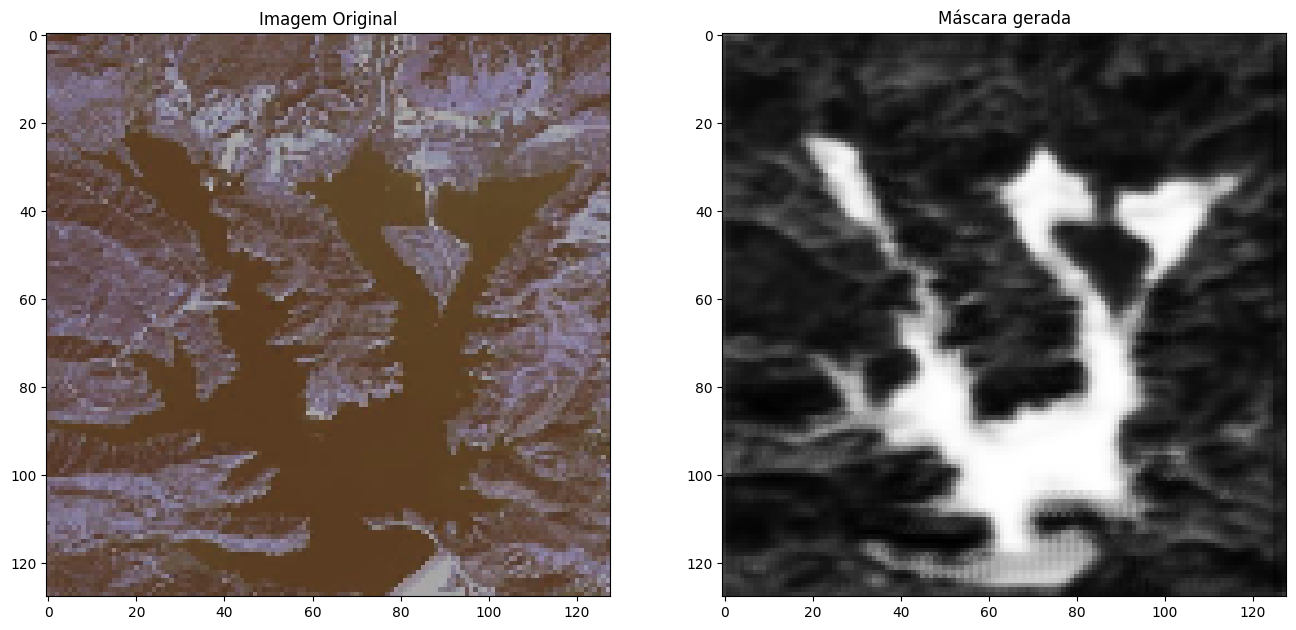

235
1/1 [==============================] - 0s 39ms/step


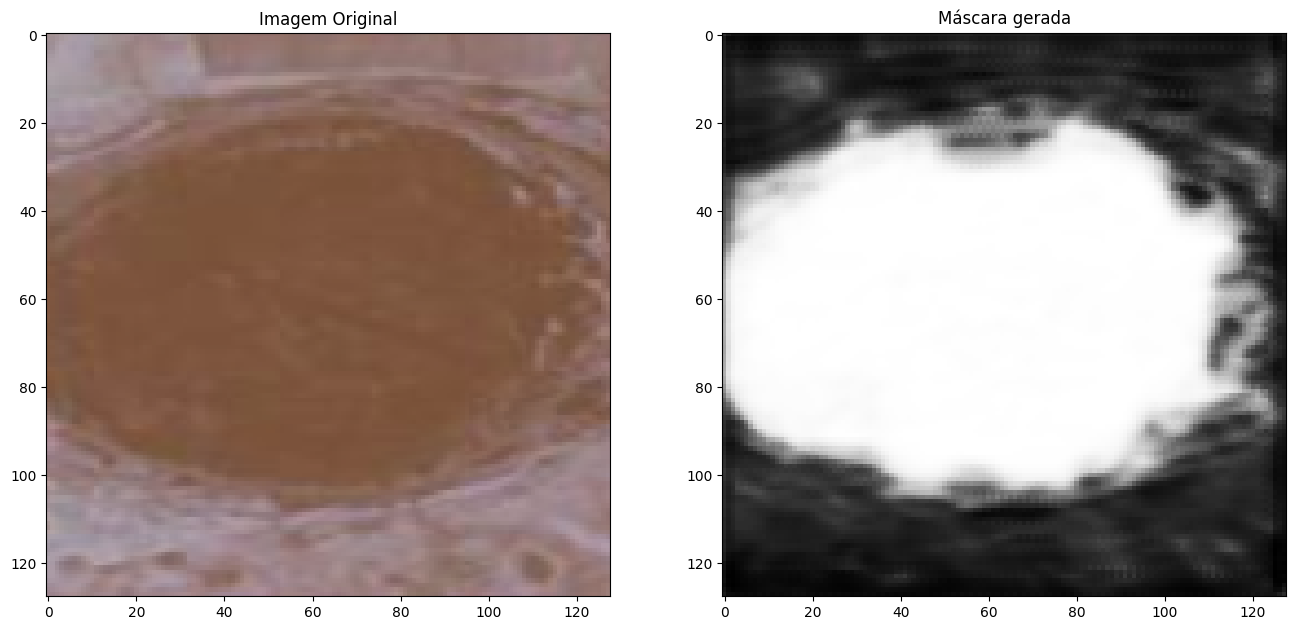

In [16]:
### Teste de previsão para imagens aleatórias
for i in range(0,20):    
    random_num = random.randint(0,len(img_test)-1)
    original_image = img_test[random_num]
    
    print(random_num)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Imagem Original')
    ####
    original_image=np.expand_dims(original_image,axis=0)
    predicted_mask = model.predict(original_image)
    predicted_mask = predicted_mask.reshape(mask_img.shape)
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask,cmap='gray')
    plt.title('Máscara gerada')
    ####
    plt.show()
    i+=1